In [1]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re

# Preprocessing
def prepocessing(lyrics, remove_stopwords=False, stops=set(stopwords.words('english'))):
    lyric_text = BeautifulSoup(lyric, "html5lib").get_text()
    lyric_text = re.sub("[^a-zA-Z]", " ", lyric_text)
    lyric_text = lyric_text.lower()
    
    lyric_words = lyric_text.split()
    if remove_stopwords:
        lyric_words = lyric_text.split()
        lyric_words = [w for w in lyric_words if not w in stops]
        
    lyric_text = ' '.join(lyric_words)
    return lyric_text

In [10]:
processed_lyrics = []
for lyric in tqdm.tqdm(df['Lyrics'].values):
    processed = prepocessing(lyric, remove_stopwords=True)
    processed_lyrics.append(processed)

100%|████████████████████████████████████████████████████████████████████████| 249948/249948 [01:53<00:00, 2211.00it/s]


In [1]:
# Create dataset

import pandas as pd
import tqdm

df = pd.read_csv('./preprocessed_train_data.csv')

df.head(5)

,Genre,Lyrics
0,Rock,it starts with pain followed by hate fueled by...
1,Rock,freedom alone again again alone patiently wait...
2,Rock,biting the hand that feeds you lying to the vo...
3,Rock,you say you know just who i am but you can t i...
4,Rock,my heart is beating faster can t control these...


In [2]:
df['Genre'].value_counts()

Rock          107016
Pop            86217
Metal          19098
Jazz           13314
Folk            8165
Indie           7240
R&B             2763
Hip-Hop         2238
Electronic      2002
Country         1890
Name: Genre, dtype: int64

In [6]:
import os
import re
import string
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [7]:
%load_ext tensorboard

In [8]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=num_ns,
              unique=True,
              range_max=vocab_size,
              seed=SEED,
              name="negative_sampling")

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [10]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and number of words in a sequence.
vocab_size = 4096
sequence_length = 10
num_ns = 4

# Use the TextVectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [11]:
vectorize_layer.adapt(df['Lyrics'])

In [12]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'i', 'you', 'the', 'to', 'and', 'a', 'it', 'me', 's', 't', 'my', 'in', 'that', 'of', 'your', 'm', 'on', 'we']


In [13]:
ds = tf.data.Dataset.from_tensor_slices(df['Lyrics'])

In [14]:
# Vectorize the data in text_ds.
text_vector_ds = ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [15]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

249943


In [16]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[   8  959   31  275 2475   99  367    1   99    4] => ['it', 'starts', 'with', 'pain', 'followed', 'by', 'hate', '[UNK]', 'by', 'the']
[ 846  165  117  117  165 3435  254   99    4  577] => ['freedom', 'alone', 'again', 'again', 'alone', 'patiently', 'waiting', 'by', 'the', 'phone']
[  1   4 211  14   1   3 857   5   4 570] => ['[UNK]', 'the', 'hand', 'that', '[UNK]', 'you', 'lying', 'to', 'the', 'voice']
[  3  68   3  28  32  97   2 141  30   3] => ['you', 'say', 'you', 'know', 'just', 'who', 'i', 'am', 'but', 'you']
[  12   88   23 1190 1246   21   11  466  156  820] => ['my', 'heart', 'is', 'beating', 'faster', 'can', 't', 'control', 'these', 'feelings']


In [17]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=3,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|█████████████████████████████████████████████████████████████████████████| 249943/249943 [18:42<00:00, 222.62it/s]




targets.shape: (1116085,)
contexts.shape: (1116085, 5)
labels.shape: (1116085, 5)


In [18]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>


In [19]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
                                           embedding_dim,
                                           input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [20]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [21]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    verbose=1,
    patience=3
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

In [96]:
history = word2vec.fit(dataset, epochs=200, callbacks=[tensorboard_callback, earlystop, learning_rate])

Epoch 1/200
808/808 [==============================] - 7s 8ms/step - loss: 1.4385 - accuracy: 0.3948 - lr: 0.0010
Epoch 2/200
808/808 [==============================] - 6s 8ms/step - loss: 1.2489 - accuracy: 0.4939 - lr: 0.0010
Epoch 3/200
808/808 [==============================] - 7s 8ms/step - loss: 1.1558 - accuracy: 0.5417 - lr: 0.0010
Epoch 4/200
808/808 [==============================] - 7s 8ms/step - loss: 1.0879 - accuracy: 0.5743 - lr: 0.0010
Epoch 5/200
808/808 [==============================] - 7s 8ms/step - loss: 1.0330 - accuracy: 0.5995 - lr: 0.0010
Epoch 6/200
808/808 [==============================] - 7s 8ms/step - loss: 0.9864 - accuracy: 0.6202 - lr: 0.0010
Epoch 7/200
808/808 [==============================] - 7s 8ms/step - loss: 0.9457 - accuracy: 0.6383 - lr: 0.0010
Epoch 8/200
808/808 [==============================] - 7s 9ms/step - loss: 0.9096 - accuracy: 0.6541 - lr: 0.0010
Epoch 9/200
808/808 [==============================] - 7s 8ms/step - loss: 0.8772 - accu

808/808 [==============================] - 7s 9ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 2.4414e-07
Epoch 134/200
808/808 [==============================] - 7s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 2.4414e-07
Epoch 135/200
808/808 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8160
Epoch 00135: ReduceLROnPlateau reducing learning rate to 1e-07.
808/808 [==============================] - 7s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 2.4414e-07
Epoch 136/200
808/808 [==============================] - 6s 7ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 137/200
808/808 [==============================] - 6s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 138/200
808/808 [==============================] - 7s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 139/200
808/808 [==============================] - 7s 9ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 140/200
808/808 [==

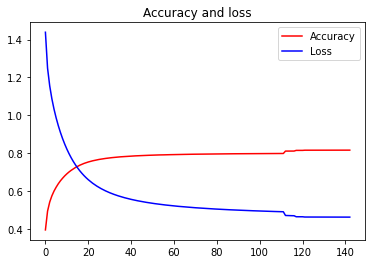

<Figure size 432x288 with 0 Axes>

In [97]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()

plt.show()

# 3-gram and 6 negative samples

In [37]:
history = word2vec.fit(dataset, epochs=200, callbacks=[tensorboard_callback, earlystop, learning_rate])

Epoch 1/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.7435 - accuracy: 0.3211 - lr: 0.0010
Epoch 2/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.5599 - accuracy: 0.4054 - lr: 0.0010
Epoch 3/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.4712 - accuracy: 0.4461 - lr: 0.0010
Epoch 4/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.4058 - accuracy: 0.4736 - lr: 0.0010
Epoch 5/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.3524 - accuracy: 0.4953 - lr: 0.0010
Epoch 6/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.3071 - accuracy: 0.5131 - lr: 0.0010
Epoch 7/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.2680 - accuracy: 0.5282 - lr: 0.0010
Epoch 8/200
1090/1090 [==============================] - 9s 8ms/step - loss: 1.2338 - accuracy: 0.5412 - lr: 0.0010
Epoch 9/200
1090/1090 [==============================] - 9s 8ms/step - l

1090/1090 [==============================] - 9s 8ms/step - loss: 0.8772 - accuracy: 0.6590 - lr: 0.0010
Epoch 72/200
1090/1090 [==============================] - 8s 8ms/step - loss: 0.8764 - accuracy: 0.6591 - lr: 0.0010
Epoch 73/200
1090/1090 [==============================] - 8s 8ms/step - loss: 0.8754 - accuracy: 0.6594 - lr: 0.0010
Epoch 74/200
1090/1090 [==============================] - 8s 8ms/step - loss: 0.8746 - accuracy: 0.6596 - lr: 0.0010
Epoch 75/200
1090/1090 [==============================] - 9s 8ms/step - loss: 0.8737 - accuracy: 0.6598 - lr: 0.0010
Epoch 76/200
1090/1090 [==============================] - 8s 8ms/step - loss: 0.8730 - accuracy: 0.6599 - lr: 0.0010
Epoch 77/200
1090/1090 [==============================] - 9s 8ms/step - loss: 0.8722 - accuracy: 0.6601 - lr: 0.0010
Epoch 78/200
1090/1090 [==============================] - 9s 8ms/step - loss: 0.8714 - accuracy: 0.6602 - lr: 0.0010
Epoch 79/200
1090/1090 [==============================] - 9s 8ms/step - loss:

Epoch 136/200
1087/1090 [============================>.] - ETA: 0s - loss: 0.8148 - accuracy: 0.6833
Epoch 00136: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
1090/1090 [==============================] - 9s 8ms/step - loss: 0.8148 - accuracy: 0.6833 - lr: 1.5625e-05
Epoch 137/200
1090/1090 [==============================] - 9s 8ms/step - loss: 0.8143 - accuracy: 0.6835 - lr: 3.9063e-06
Epoch 138/200
1090/1090 [==============================] - 8s 8ms/step - loss: 0.8144 - accuracy: 0.6835 - lr: 3.9063e-06
Epoch 139/200
1090/1090 [==============================] - 9s 8ms/step - loss: 0.8143 - accuracy: 0.6835 - lr: 3.9063e-06
Epoch 140/200
1090/1090 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.6835
Epoch 00140: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
1090/1090 [==============================] - 9s 8ms/step - loss: 0.8144 - accuracy: 0.6835 - lr: 3.9063e-06
Epoch 00140: early stopping


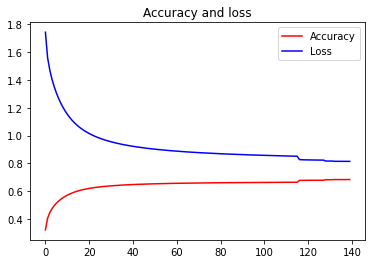

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()

plt.show()

In [98]:
word2vec.save('word2vec-second-train')

INFO:tensorflow:Assets written to: word2vec-second-train\assets


# Sequence length = 50

In [39]:
history = word2vec.fit(dataset, epochs=200, callbacks=[tensorboard_callback, earlystop, learning_rate])

Epoch 1/200
6394/6394 [==============================] - 57s 9ms/step - loss: 1.3040 - accuracy: 0.4513 - lr: 0.0010
Epoch 2/200
6394/6394 [==============================] - 53s 8ms/step - loss: 1.1810 - accuracy: 0.5091 - lr: 0.0010
Epoch 3/200
6394/6394 [==============================] - 55s 9ms/step - loss: 1.1177 - accuracy: 0.5342 - lr: 0.0010
Epoch 4/200
6394/6394 [==============================] - 54s 8ms/step - loss: 1.0744 - accuracy: 0.5499 - lr: 0.0010
Epoch 5/200
6394/6394 [==============================] - 53s 8ms/step - loss: 1.0454 - accuracy: 0.5596 - lr: 0.0010
Epoch 6/200
6394/6394 [==============================] - 53s 8ms/step - loss: 1.0267 - accuracy: 0.5649 - lr: 0.0010
Epoch 7/200
6394/6394 [==============================] - 53s 8ms/step - loss: 1.0147 - accuracy: 0.5678 - lr: 0.0010
Epoch 8/200
6394/6394 [==============================] - 53s 8ms/step - loss: 1.0070 - accuracy: 0.5691 - lr: 0.0010
Epoch 9/200
6394/6394 [==============================] - 53s 8ms

KeyboardInterrupt: 

# Window size 5, seq length 10

In [22]:
history = word2vec.fit(dataset, epochs=200, callbacks=[tensorboard_callback, earlystop, learning_rate])

Epoch 1/200
2389/2389 [==============================] - 21s 8ms/step - loss: 1.3676 - accuracy: 0.4154 - lr: 0.0010
Epoch 2/200
2389/2389 [==============================] - 19s 8ms/step - loss: 1.2097 - accuracy: 0.5061 - lr: 0.0010
Epoch 3/200
2389/2389 [==============================] - 19s 8ms/step - loss: 1.1135 - accuracy: 0.5572 - lr: 0.0010
Epoch 4/200
2389/2389 [==============================] - 19s 8ms/step - loss: 1.0409 - accuracy: 0.5935 - lr: 0.0010
Epoch 5/200
2389/2389 [==============================] - 19s 8ms/step - loss: 0.9833 - accuracy: 0.6204 - lr: 0.0010
Epoch 6/200
2389/2389 [==============================] - 19s 8ms/step - loss: 0.9368 - accuracy: 0.6413 - lr: 0.0010
Epoch 7/200
2389/2389 [==============================] - 19s 8ms/step - loss: 0.8988 - accuracy: 0.6576 - lr: 0.0010
Epoch 8/200
2389/2389 [==============================] - 19s 8ms/step - loss: 0.8674 - accuracy: 0.6707 - lr: 0.0010
Epoch 9/200
2389/2389 [==============================] - 19s 8ms

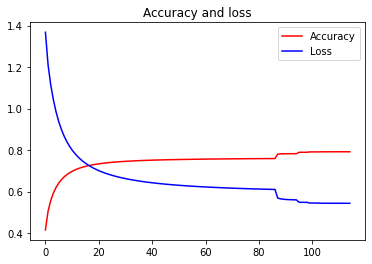

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()

plt.show()

In [ ]:
word2vec.save('word2vec-50seq')

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
word2vec.get_layer('w2v_embedding')

In [103]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [30]:
x = df['Lyrics'].values
y = np.array(pd.Categorical(pd.factorize(df['Genre'])[0]))

In [32]:
BUFFER_SIZE = 10000
BATCH_SIZE = 1024

train_ds = tf.data.Dataset.from_tensor_slices((x, y))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [33]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))   

In [34]:
my_word2vec = tf.keras.models.load_model('word2vec')

In [ ]:
class GenreClassifier(tf.keras.Model):
    
    def __init__(self):
        super(GenreClassifier, self).__init__()    
        self.encoder = encoder
        self.embed = my_word2vec.get_layer('w2v_embedding')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.predict = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.embed(x)
        x = self.lstm(x)VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))   
        x = self.dense1(x)
        return self.predict(x)
    

In [35]:
model = tf.keras.Sequential([
    encoder,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [36]:
model.layers[0].trainable = False
model.layers[1].trainable = False

In [37]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.3, random_state=42
)

In [39]:
num_data = []
total = len(x)

for genre in df['Genre'].unique():
    num_data.append(len(df[df['Genre'] == genre]))

print(num_data)

[107019, 19098, 86219, 7240, 8165, 2002, 2763, 13314, 2238, 1890]


Rock: 0
Pop: 1
Metal: 2
Jazz: 3
Folk: 4
Indie: 5
R&B: 6
Hip-Hop: 7
Electronic: 8
Country: 9

In [40]:
class_weight = {
    0: 1 - num_data[0] / total,
    1: 1 - num_data[1] / total,
    2: 1 - num_data[2] / total,
    3: 1 - num_data[3] / total,
    4: 1 - num_data[4] / total,
    5: 1 - num_data[5] / total,
    6: 1 - num_data[6] / total,
    7: 1 - num_data[7] / total,
    8: 1 - num_data[8] / total,
    9: 1 - num_data[9] / total
}

In [40]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_2bidrection',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

In [42]:
history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate, model_checkpoint],
    class_weight=class_weight
)

Epoch 1/50
5468/5468 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.4455
Epoch 00001: val_accuracy improved from -inf to 0.47281, saving model to best_model_2bidrection


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


5468/5468 [==============================] - 367s 66ms/step - loss: 1.1269 - accuracy: 0.4455 - val_loss: 1.4389 - val_accuracy: 0.4728 - lr: 1.0000e-04
Epoch 2/50
5467/5468 [============================>.] - ETA: 0s - loss: 1.0729 - accuracy: 0.5194
Epoch 00002: val_accuracy improved from 0.47281 to 0.53991, saving model to best_model_2bidrection


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


5468/5468 [==============================] - 363s 66ms/step - loss: 1.0729 - accuracy: 0.5194 - val_loss: 1.3767 - val_accuracy: 0.5399 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - ETA: 0s - loss: 1.0527 - accuracy: 0.5369
Epoch 00003: val_accuracy did not improve from 0.53991
5468/5468 [==============================] - 355s 65ms/step - loss: 1.0527 - accuracy: 0.5369 - val_loss: 1.3821 - val_accuracy: 0.5285 - lr: 1.0000e-04
Epoch 4/50
5467/5468 [============================>.] - ETA: 0s - loss: 1.0430 - accuracy: 0.5389
Epoch 00004: val_accuracy improved from 0.53991 to 0.54234, saving model to best_model_2bidrection


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


5468/5468 [==============================] - 360s 66ms/step - loss: 1.0430 - accuracy: 0.5389 - val_loss: 1.3391 - val_accuracy: 0.5423 - lr: 1.0000e-04
Epoch 5/50
5467/5468 [============================>.] - ETA: 0s - loss: 1.0350 - accuracy: 0.5375
Epoch 00005: val_accuracy did not improve from 0.54234
5468/5468 [==============================] - 351s 64ms/step - loss: 1.0350 - accuracy: 0.5375 - val_loss: 1.3334 - val_accuracy: 0.5395 - lr: 1.0000e-04
Epoch 6/50
5468/5468 [==============================] - ETA: 0s - loss: 1.0279 - accuracy: 0.5387
Epoch 00006: val_accuracy did not improve from 0.54234
5468/5468 [==============================] - 352s 64ms/step - loss: 1.0279 - accuracy: 0.5387 - val_loss: 1.3331 - val_accuracy: 0.5306 - lr: 1.0000e-04
Epoch 7/50
5468/5468 [==============================] - ETA: 0s - loss: 1.0234 - accuracy: 0.5391
Epoch 00007: val_accuracy improved from 0.54234 to 0.54576, saving model to best_model_2bidrection


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


5468/5468 [==============================] - 358s 66ms/step - loss: 1.0234 - accuracy: 0.5391 - val_loss: 1.3372 - val_accuracy: 0.5458 - lr: 1.0000e-04
Epoch 8/50
5468/5468 [==============================] - ETA: 0s - loss: 1.0191 - accuracy: 0.5402
Epoch 00008: val_accuracy did not improve from 0.54576
5468/5468 [==============================] - 351s 64ms/step - loss: 1.0191 - accuracy: 0.5402 - val_loss: 1.3591 - val_accuracy: 0.5205 - lr: 1.0000e-04
Epoch 9/50
5467/5468 [============================>.] - ETA: 0s - loss: 1.0160 - accuracy: 0.5416
Epoch 00009: val_accuracy did not improve from 0.54576
5468/5468 [==============================] - 363s 66ms/step - loss: 1.0160 - accuracy: 0.5416 - val_loss: 1.3312 - val_accuracy: 0.5414 - lr: 1.0000e-04
Epoch 10/50
5468/5468 [==============================] - ETA: 0s - loss: 1.0125 - accuracy: 0.5415
Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00010: val_accuracy did not improve from 0.54576


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


5468/5468 [==============================] - 380s 69ms/step - loss: 0.9959 - accuracy: 0.5480 - val_loss: 1.2935 - val_accuracy: 0.5496 - lr: 2.5000e-05
Epoch 14/50
5468/5468 [==============================] - ETA: 0s - loss: 0.9949 - accuracy: 0.5482
Epoch 00014: val_accuracy improved from 0.54959 to 0.55183, saving model to best_model_2bidrection


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


INFO:tensorflow:Assets written to: best_model_2bidrection\assets


5468/5468 [==============================] - 380s 70ms/step - loss: 0.9949 - accuracy: 0.5482 - val_loss: 1.2910 - val_accuracy: 0.5518 - lr: 2.5000e-05
Epoch 15/50
5467/5468 [============================>.] - ETA: 0s - loss: 0.9940 - accuracy: 0.5490
Epoch 00015: val_accuracy did not improve from 0.55183
5468/5468 [==============================] - 368s 67ms/step - loss: 0.9939 - accuracy: 0.5490 - val_loss: 1.2923 - val_accuracy: 0.5480 - lr: 2.5000e-05
Epoch 16/50
5467/5468 [============================>.] - ETA: 0s - loss: 0.9930 - accuracy: 0.5482
Epoch 00016: val_accuracy did not improve from 0.55183
5468/5468 [==============================] - 363s 66ms/step - loss: 0.9930 - accuracy: 0.5482 - val_loss: 1.2914 - val_accuracy: 0.5514 - lr: 2.5000e-05
Epoch 17/50
5467/5468 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.5488
Epoch 00017: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00017: val_accuracy did not improve from 0.55183

# Plot 128 LSTM cell

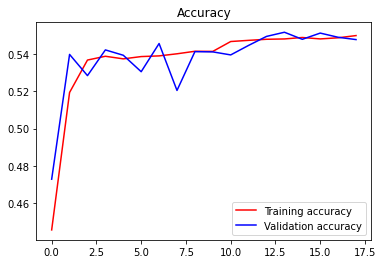

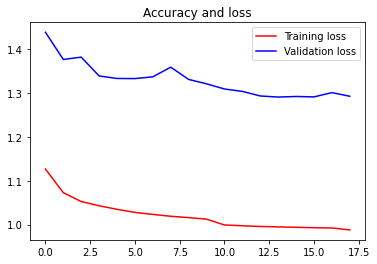

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

# After 50 epochs

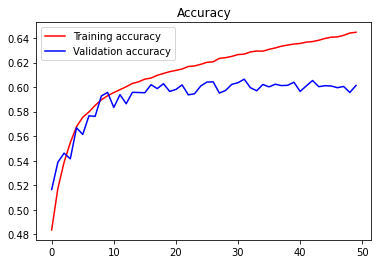

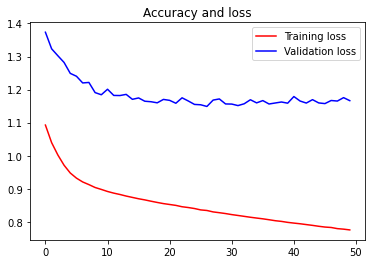

<Figure size 432x288 with 0 Axes>

In [85]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [86]:
model.save('epoch50')

INFO:tensorflow:Assets written to: epoch50\assets


INFO:tensorflow:Assets written to: epoch50\assets


# Same with first train but no class weight

In [42]:
history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
)

Epoch 1/50
5468/5468 [==============================] - 306s 54ms/step - loss: 1.3884 - accuracy: 0.5241 - val_loss: 1.3429 - val_accuracy: 0.5499 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - 296s 54ms/step - loss: 1.3427 - accuracy: 0.5499 - val_loss: 1.3366 - val_accuracy: 0.5519 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - 301s 55ms/step - loss: 1.3351 - accuracy: 0.5506 - val_loss: 1.3258 - val_accuracy: 0.5477 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - 286s 52ms/step - loss: 1.3170 - accuracy: 0.5518 - val_loss: 1.3051 - val_accuracy: 0.5503 - lr: 1.0000e-04
Epoch 5/50
5468/5468 [==============================] - 296s 54ms/step - loss: 1.2999 - accuracy: 0.5536 - val_loss: 1.2899 - val_accuracy: 0.5557 - lr: 1.0000e-04
Epoch 6/50
5468/5468 [==============================] - 289s 53ms/step - loss: 1.2915 - accuracy: 0.5549 - val_loss: 1.2861 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 7/50
5468/

5467/5468 [============================>.] - ETA: 0s - loss: 1.2331 - accuracy: 0.5712
Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-07.
5468/5468 [==============================] - 325s 59ms/step - loss: 1.2331 - accuracy: 0.5712 - val_loss: 1.2376 - val_accuracy: 0.5688 - lr: 3.9062e-07
Epoch 47/50
5468/5468 [==============================] - 312s 57ms/step - loss: 1.2329 - accuracy: 0.5714 - val_loss: 1.2375 - val_accuracy: 0.5689 - lr: 1.0000e-07
Epoch 48/50
5468/5468 [==============================] - 365s 67ms/step - loss: 1.2329 - accuracy: 0.5717 - val_loss: 1.2375 - val_accuracy: 0.5689 - lr: 1.0000e-07
Epoch 49/50
5468/5468 [==============================] - 332s 61ms/step - loss: 1.2330 - accuracy: 0.5714 - val_loss: 1.2375 - val_accuracy: 0.5687 - lr: 1.0000e-07
Epoch 50/50
5468/5468 [==============================] - 335s 61ms/step - loss: 1.2329 - accuracy: 0.5716 - val_loss: 1.2375 - val_accuracy: 0.5686 - lr: 1.0000e-07


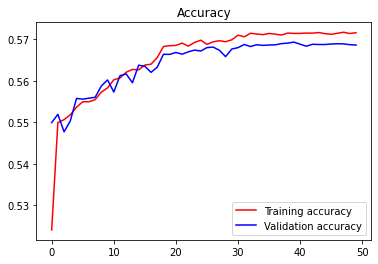

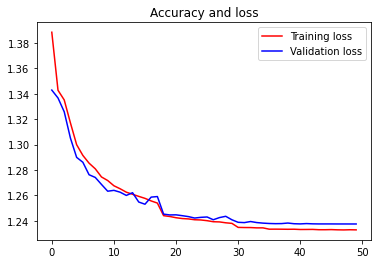

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [44]:
model.save('./non-class-weight')

INFO:tensorflow:Assets written to: ./non-class-weight\assets


INFO:tensorflow:Assets written to: ./non-class-weight\assets


# Additional train

In [53]:
model.load_weights('./epoch50/variables/variables')

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 w2v_embedding (Embedding)   (None, None, 128)         524288    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 632,010
Trainable params: 107,722
Non-trai

In [56]:
history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate, model_checkpoint],
    class_weight=class_weight
)

Epoch 1/50
5467/5468 [============================>.] - ETA: 0s - loss: 0.7732 - accuracy: 0.6446
Epoch 00001: val_accuracy improved from -inf to 0.60469, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


5468/5468 [==============================] - 291s 53ms/step - loss: 0.7732 - accuracy: 0.6446 - val_loss: 1.1613 - val_accuracy: 0.6047 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - ETA: 0s - loss: 0.7714 - accuracy: 0.6454
Epoch 00002: val_accuracy did not improve from 0.60469
5468/5468 [==============================] - 284s 52ms/step - loss: 0.7714 - accuracy: 0.6454 - val_loss: 1.1699 - val_accuracy: 0.6003 - lr: 1.0000e-04
Epoch 3/50
5467/5468 [============================>.] - ETA: 0s - loss: 0.7693 - accuracy: 0.6460
Epoch 00003: val_accuracy did not improve from 0.60469
5468/5468 [==============================] - 288s 53ms/step - loss: 0.7693 - accuracy: 0.6460 - val_loss: 1.1674 - val_accuracy: 0.6029 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - ETA: 0s - loss: 0.7667 - accuracy: 0.6476
Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00004: val_accuracy did not improve from 0.60469
5

# None Bidrection.

In [82]:
model = tf.keras.Sequential([
    encoder,
    word2vec.layers[0],
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.layers[0].trainable = False
model.layers[1].trainable = False

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)


history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate, model_checkpoint],
    class_weight=class_weight
)

Epoch 1/50
5467/5468 [============================>.] - ETA: 0s - loss: 1.1343 - accuracy: 0.4513 ETA
Epoch 00001: val_accuracy did not improve from 0.60469
5468/5468 [==============================] - 173s 31ms/step - loss: 1.1343 - accuracy: 0.4513 - val_loss: 1.4591 - val_accuracy: 0.4606 - lr: 1.0000e-04
Epoch 2/50
5467/5468 [============================>.] - ETA: 0s - loss: 1.1157 - accuracy: 0.4683
Epoch 00002: val_accuracy did not improve from 0.60469
5468/5468 [==============================] - 158s 29ms/step - loss: 1.1156 - accuracy: 0.4683 - val_loss: 1.4451 - val_accuracy: 0.4895 - lr: 1.0000e-04
Epoch 3/50
5466/5468 [============================>.] - ETA: 0s - loss: 1.1005 - accuracy: 0.4941
Epoch 00003: val_accuracy did not improve from 0.60469
5468/5468 [==============================] - 154s 28ms/step - loss: 1.1005 - accuracy: 0.4941 - val_loss: 1.4077 - val_accuracy: 0.5206 - lr: 1.0000e-04
Epoch 4/50
5466/5468 [============================>.] - ETA: 0s - loss: 1.0797

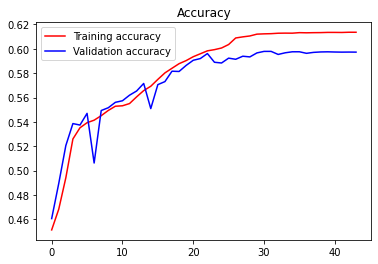

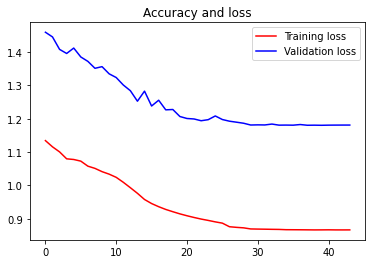

<Figure size 432x288 with 0 Axes>

In [83]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [84]:
model.save('non-bidirection')

INFO:tensorflow:Assets written to: non-bidirection\assets


INFO:tensorflow:Assets written to: non-bidirection\assets


In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.layers[0].trainable = False
model.layers[1].trainable = False

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.3, random_state=42
)

num_data = []
total = len(x)

for genre in df['Genre'].unique():
    num_data.append(len(df[df['Genre'] == genre]))

print(num_data)

class_weight = {
    0: 1 - num_data[0] / total,
    1: 1 - num_data[1] / total,
    2: 1 - num_data[2] / total,
    3: 1 - num_data[3] / total,
    4: 1 - num_data[4] / total,
    5: 1 - num_data[5] / total,
    6: 1 - num_data[6] / total,
    7: 1 - num_data[7] / total,
    8: 1 - num_data[8] / total,
    9: 1 - num_data[9] / total
}

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate, model_checkpoint],
    class_weight=class_weight
)

import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()